<a href="https://colab.research.google.com/github/FlaviaFerranti7/CNN_Art/blob/master/FinalProject_Visiope.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

data available at: https://drive.google.com/drive/folders/1Ion5D0NoWUcjVzNo39eG9-8yQVbvOtyN?usp=sharing

# Importing packages

In [ ]:
%tensorflow_version 2.x

from google.colab import drive

import matplotlib.pyplot as plt
import numpy as np
import os, sys
import PIL
from PIL import Image
import glob
import IPython.display as display

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

AUTOTUNE = tf.data.experimental.AUTOTUNE

Found GPU at: /device:GPU:0


# Creating dataset

In [ ]:
drive.mount('/content/drive', force_remount=True)
root_dir = '/content/drive/My Drive/vision_project/dataset/'

Mounted at /content/drive


## Manipulating folder image size

In [ ]:
def aspect_ratio_resize_smart(img,base=256): #img is a PIL image variable
    if img.size[0] <= img.size[1]:
        basewidth = base
        wpercent = (basewidth/float(img.size[0]))
        hsize = int((float(img.size[1])*float(wpercent)))
        img = img.resize((basewidth,hsize),PIL.Image.LANCZOS)
    else:
        baseheight = base
        wpercent = (baseheight/float(img.size[1]))
        wsize = int((float(img.size[0])*float(wpercent)))
        img = img.resize((wsize,baseheight),PIL.Image.LANCZOS)
    return img

In [ ]:
for filename in glob.iglob(root_dir + '**/*.*', recursive=True):
    print(filename)
    im = Image.open(filename)
    imResize = aspect_ratio_resize_smart(im,base=256)
    if imResize.size[0] < 224 or imResize.size[1]<224:
      print(imResize.size[0],imResize.size[1])
    imResize.save(filename , 'JPEG', quality=90)

/content/drive/My Drive/vision_project/dataset/REMBRANDT/REMBRANDT_002_ORI.jpg
/content/drive/My Drive/vision_project/dataset/REMBRANDT/REMBRANDT_003_ORI.jpg
/content/drive/My Drive/vision_project/dataset/REMBRANDT/REMBRANDT_004_ORI.jpg
/content/drive/My Drive/vision_project/dataset/REMBRANDT/REMBRANDT_007_ORI.jpg
/content/drive/My Drive/vision_project/dataset/REMBRANDT/REMBRANDT_008_ORI.jpg
/content/drive/My Drive/vision_project/dataset/REMBRANDT/REMBRANDT_009_ORI.jpg
/content/drive/My Drive/vision_project/dataset/REMBRANDT/REMBRANDT_010_ORI.jpg
/content/drive/My Drive/vision_project/dataset/REMBRANDT/REMBRANDT_011_ORI.JPG
/content/drive/My Drive/vision_project/dataset/REMBRANDT/REMBRANDT_012_ORI.jpg
/content/drive/My Drive/vision_project/dataset/REMBRANDT/REMBRANDT_013_ORI.jpg
/content/drive/My Drive/vision_project/dataset/REMBRANDT/REMBRANDT_014_ORI.jpg
/content/drive/My Drive/vision_project/dataset/REMBRANDT/REMBRANDT_015_ORI.JPG
/content/drive/My Drive/vision_project/dataset/REMBR

## Training set and test set

In [ ]:
import pathlib
dir_root=pathlib.Path("/content/drive/My Drive/vision_project/dataset")

In [ ]:
image_count = len(list(glob.iglob(root_dir + '*/*.*')))
image_count

1000

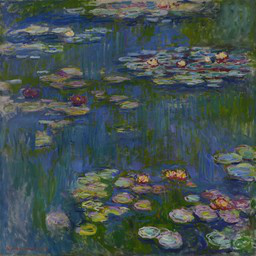

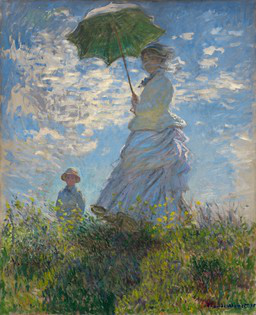

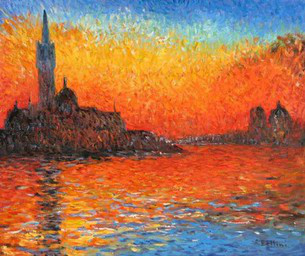

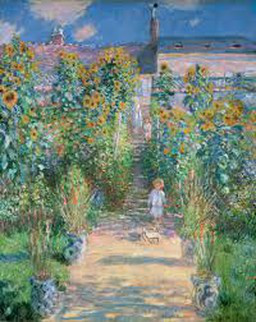

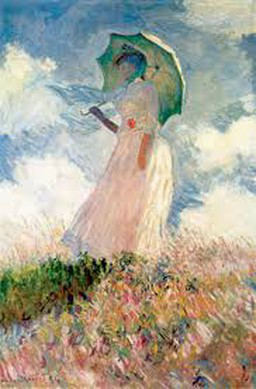

In [ ]:
artwork = list(glob.iglob(root_dir + 'MONET/*.*'))

for image_path in artwork[:5]:
    display.display(Image.open(str(image_path)))

In [ ]:
list_ds = tf.data.Dataset.list_files(str(dir_root/"*/*"), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)
for f in list_ds.take(5):
  print(f.numpy())

b'/content/drive/My Drive/vision_project/dataset/MAGRITTE/MAGRITTE_031_ORI.jpg'
b'/content/drive/My Drive/vision_project/dataset/GENTILESCHI/GENTILESCHI_040_ORI.jpg'
b'/content/drive/My Drive/vision_project/dataset/VANGOGH/VANGOGH_097_ORI.jpg'
b'/content/drive/My Drive/vision_project/dataset/MONET/MONET_085_ORI.jpg'
b'/content/drive/My Drive/vision_project/dataset/DALI/DALI_019_ORI.jpg'


In [ ]:
CLASS_NAMES = np.array([item.name for item in dir_root.glob('*') ])
CLASS_NAMES

array(['REMBRANDT', 'MONET', 'RENOIR', 'ESCHER', 'GENTILESCHI',
       'CARAVAGGIO', 'VANGOGH', 'DALI', 'MAGRITTE', 'GONSALVES'],
      dtype='<U11')

In [ ]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.sep)
  return parts[-2] == CLASS_NAMES

In [ ]:
def decode_img(img):
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  return img

In [ ]:
def process_path(file_path):
  label = get_label(file_path)
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [ ]:
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
for image, label in labeled_ds:
  if image.shape[0]<224 or image.shape[1]<224:
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

In [ ]:
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (256, 341, 3)
Label:  [False False False False False  True False False False False]


Splitting training and test

In [ ]:
def is_test(x, y):
    return x % 5 == 0

def is_train(x, y):
    return not is_test(x, y)

recover = lambda x,y: y

test_dataset = labeled_ds.enumerate() \
                    .filter(is_test) \
                    .map(recover)

train_dataset = labeled_ds.enumerate() \
                    .filter(is_train) \
                    .map(recover)

In [ ]:
BATCH_SIZE = 32

Augmented data on training set

In [ ]:
def full_augment(img, label):
  img = tf.image.random_crop(img, size=[224, 224, 3]) 
  img = tf.image.random_brightness(img, max_delta=0.2)
  img = tf.image.random_flip_left_right(img) 
  img = tf.image.random_saturation(img, 0.6, 1.6) 
  img = tf.image.random_contrast(img, 0.7, 1.3)
  img = tf.image.random_hue(img, 0.08)
  return img, label

In [ ]:
def less_augment(img, label):
  img = tf.image.random_crop(img, size=[224, 224, 3]) 
  img = tf.image.random_flip_left_right(img) 
  img = tf.image.random_contrast(img, 0.7, 1.3)
  return img, label

In [ ]:
def choose_augmentation(ds, flag):
  if flag == True:
    ds = ds.map(full_augment, num_parallel_calls=AUTOTUNE)
  else:
    ds = ds.map(less_augment, num_parallel_calls=AUTOTUNE)
  return ds

In [ ]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=100, flag=True):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = choose_augmentation(ds, flag)
  ds = ds.shuffle(buffer_size=shuffle_buffer_size, reshuffle_each_iteration=True)

  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE)

  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [ ]:
train_ds = prepare_for_training(train_dataset, flag=False)

In [ ]:
input_shape = (224,224,3)
input_shape

(224, 224, 3)

In [ ]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

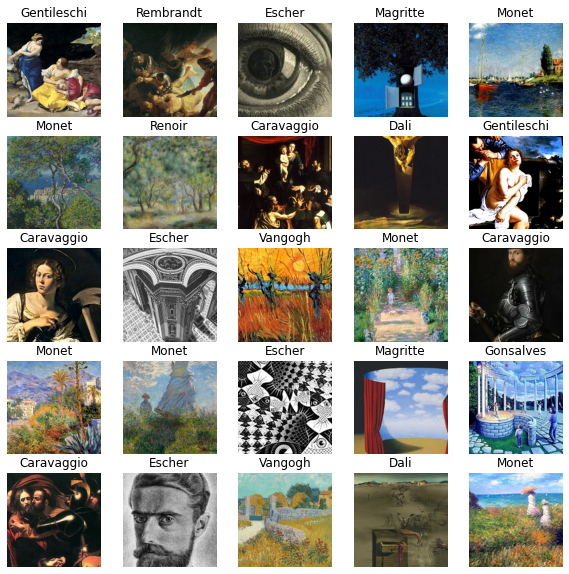

In [ ]:
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

### Manipulating test images

In [ ]:
def central_crop(img, label):
  img = tf.image.resize_with_crop_or_pad(img,224,224)
  return img, label

In [ ]:
test_ds = test_dataset.map(central_crop, num_parallel_calls=AUTOTUNE)

In [ ]:
for image, label in test_ds:
  if image.shape[0]!=224 or image.shape[1]!=224:
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

In [ ]:
def prepare_for_test(ds, cache=True, BATCH_SIZE=BATCH_SIZE):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE)

  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [ ]:
test_ds = prepare_for_test(test_ds)

### Second possibility of manipulating test images

In [ ]:
def resize_test_image(img, label):
  img = tf.image.resize(img, (224,224))
  return img, label

In [ ]:
test_ds = test_dataset.map(resize_test_image, num_parallel_calls=AUTOTUNE)

In [ ]:
for image, label in test_ds:
  if image.shape[0]!=224 or image.shape[1]!=224:
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

In [ ]:
def prepare_for_test(ds, cache=True):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

 
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE)


  return ds

In [ ]:
test_ds = prepare_for_test(test_ds)

# Building model

## Model from scratch with full data augmentation

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='same'))

model.add(layers.Conv2D(32, (3, 3), activation='relu', strides=(2,2), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='same'))

model.add(layers.Conv2D(64, (5, 5), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(3, 3), strides=(2,2), padding='same'))

model.add(layers.Conv2D(128, (7, 7), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (7, 7), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(3, 3), padding='same'))

model.add(layers.Conv2D(256, (5, 5), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(3, 3), padding='same'))

model.add(layers.Flatten())

model.add(layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(512, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(10, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_92 (Conv2D)           (None, 224, 224, 16)      448       
_________________________________________________________________
batch_normalization_116 (Bat (None, 224, 224, 16)      64        
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 56, 56, 32)        4640      
_________________________________________________________________
batch_normalization_117 (Bat (None, 56, 56, 32)        128       
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 56, 56, 64)        18496     
_________________________________________________________________
batch_normalization_118 (Bat (None, 56, 56, 64)       

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [ ]:
stopping = EarlyStopping(monitor='val_accuracy', patience = 15, restore_best_weights = True)
steps_per_epoch=np.ceil(800/BATCH_SIZE)
val_steps=np.ceil(200/BATCH_SIZE)

try:
    history = model.fit_generator(train_ds, epochs=120, verbose=1,\
                    callbacks=[stopping],\
                    steps_per_epoch=steps_per_epoch,\
                    validation_data=test_ds,\
                    validation_steps=val_steps)
except KeyboardInterrupt:
    pass

Epoch 1/120
25/25 [==============================] - 3s 111ms/step - loss: 4.8548 - accuracy: 0.1713 - val_loss: 6.3005 - val_accuracy: 0.0938
Epoch 2/120
25/25 [==============================] - 3s 101ms/step - loss: 4.1944 - accuracy: 0.2362 - val_loss: 9.3655 - val_accuracy: 0.0848
Epoch 3/120
25/25 [==============================] - 3s 104ms/step - loss: 3.9605 - accuracy: 0.2675 - val_loss: 9.7464 - val_accuracy: 0.0848
Epoch 4/120
25/25 [==============================] - 3s 104ms/step - loss: 3.8112 - accuracy: 0.3050 - val_loss: 9.3933 - val_accuracy: 0.0848
Epoch 5/120
25/25 [==============================] - 3s 107ms/step - loss: 3.7098 - accuracy: 0.3063 - val_loss: 7.8352 - val_accuracy: 0.1027
Epoch 6/120
25/25 [==============================] - 3s 104ms/step - loss: 3.4468 - accuracy: 0.3663 - val_loss: 5.7067 - val_accuracy: 0.1473
Epoch 7/120
25/25 [==============================] - 3s 104ms/step - loss: 3.4771 - accuracy: 0.3750 - val_loss: 4.4627 - val_accuracy: 0.2634

7/7 [==============================] - 0s 28ms/step - loss: 1.5834 - accuracy: 0.7634
0.7633928656578064


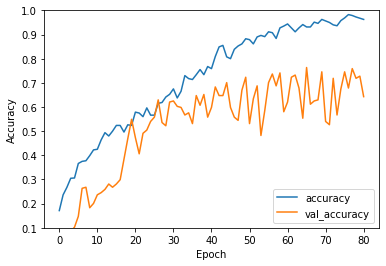

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')

test_steps = np.ceil(200/BATCH_SIZE)
test_loss, test_acc = model.evaluate(test_ds, verbose=1, steps=test_steps)
print(test_acc)

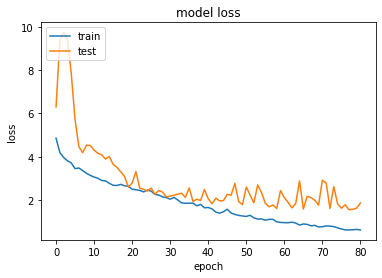

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Model from scratch with less data augmentation

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='same'))

model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='same'))

model.add(layers.Conv2D(64, (5, 5), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(3, 3), strides=(2,2), padding='same'))

model.add(layers.Conv2D(128, (7, 7), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(3, 3), padding='same'))

model.add(layers.Conv2D(256, (5, 5), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(3, 3), padding='same'))


model.add(layers.Flatten())

model.add(layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(512, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(10, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 224, 224, 16)      448       
_________________________________________________________________
batch_normalization_50 (Batc (None, 224, 224, 16)      64        
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 112, 112, 64)      9280      
_________________________________________________________________
batch_normalization_51 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 56, 56, 64)       

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [ ]:
stopping = EarlyStopping(monitor='val_accuracy', patience = 15, restore_best_weights = True)
steps_per_epoch=np.ceil(800/BATCH_SIZE)
val_steps=np.ceil(200/BATCH_SIZE)

try:
    history = model.fit_generator(train_ds, epochs=120, verbose=1,\
                    callbacks=[stopping],\
                    steps_per_epoch=steps_per_epoch,\
                    validation_data=test_ds,\
                    validation_steps=val_steps)
except KeyboardInterrupt:
    pass

Epoch 1/120
25/25 [==============================] - 1s 60ms/step - loss: 4.7612 - accuracy: 0.1937 - val_loss: 4.5282 - val_accuracy: 0.1920
Epoch 2/120
25/25 [==============================] - 1s 48ms/step - loss: 4.3499 - accuracy: 0.2700 - val_loss: 5.5445 - val_accuracy: 0.1652
Epoch 3/120
25/25 [==============================] - 1s 47ms/step - loss: 4.1352 - accuracy: 0.3013 - val_loss: 6.6533 - val_accuracy: 0.0893
Epoch 4/120
25/25 [==============================] - 1s 48ms/step - loss: 3.9276 - accuracy: 0.3350 - val_loss: 6.3744 - val_accuracy: 0.1295
Epoch 5/120
25/25 [==============================] - 1s 49ms/step - loss: 3.8586 - accuracy: 0.3475 - val_loss: 6.3761 - val_accuracy: 0.1295
Epoch 6/120
25/25 [==============================] - 1s 48ms/step - loss: 3.6382 - accuracy: 0.3800 - val_loss: 6.0945 - val_accuracy: 0.1027
Epoch 7/120
25/25 [==============================] - 1s 48ms/step - loss: 3.5433 - accuracy: 0.4013 - val_loss: 5.5130 - val_accuracy: 0.1116
Epoch 

7/7 [==============================] - 0s 16ms/step - loss: 2.0088 - accuracy: 0.7768
0.7767857313156128


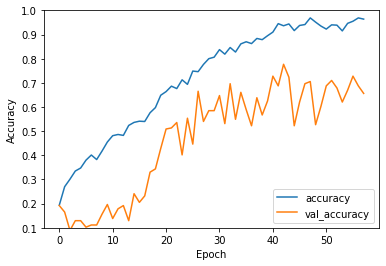

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')

test_steps = np.ceil(200/BATCH_SIZE)
test_loss, test_acc = model.evaluate(test_ds, verbose=1, steps=test_steps)
print(test_acc)

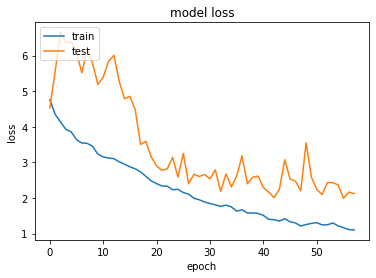

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##Pretrained model using ResNet50 with full data augmentation

In [ ]:
resnet_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
resnet_model.trainable = False

In [ ]:
inputs = tf.keras.Input(shape=input_shape)

In [ ]:
firstPartModel = resnet_model(inputs, training=False)
firstPartModel = layers.GlobalAveragePooling2D()(firstPartModel)
firstPartModel = layers.Dropout(0.5)(firstPartModel)
firstPartModel = layers.Dense(10, activation='softmax')(firstPartModel)

In [ ]:
model = tf.keras.Model(inputs=inputs, outputs=firstPartModel)
model.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_12  (None, 2048)              0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                20490     
Total params: 23,608,202
Trainable params: 20,490
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
model.compile(loss='categorical_crossentropy',
             optimizer='Adam',
             metrics=['accuracy'])

In [ ]:
steps_per_epoch=np.ceil(800/BATCH_SIZE)
val_steps=np.ceil(200/BATCH_SIZE)

try:
    history = model.fit(train_ds, epochs=80, verbose=1,\
                    steps_per_epoch=steps_per_epoch,\
                    validation_data=test_ds,\
                    validation_steps=val_steps)
except KeyboardInterrupt:
    pass

Epoch 1/80
25/25 [==============================] - 7s 295ms/step - loss: 2.6691 - accuracy: 0.1100 - val_loss: 2.2831 - val_accuracy: 0.1830
Epoch 2/80
25/25 [==============================] - 6s 249ms/step - loss: 2.4073 - accuracy: 0.1575 - val_loss: 2.2432 - val_accuracy: 0.1429
Epoch 3/80
25/25 [==============================] - 6s 252ms/step - loss: 2.2767 - accuracy: 0.1725 - val_loss: 2.2018 - val_accuracy: 0.1875
Epoch 4/80
25/25 [==============================] - 6s 252ms/step - loss: 2.2356 - accuracy: 0.1813 - val_loss: 2.1790 - val_accuracy: 0.1830
Epoch 5/80
25/25 [==============================] - 6s 252ms/step - loss: 2.1731 - accuracy: 0.1863 - val_loss: 2.1547 - val_accuracy: 0.2143
Epoch 6/80
25/25 [==============================] - 6s 253ms/step - loss: 2.1457 - accuracy: 0.1925 - val_loss: 2.1481 - val_accuracy: 0.2500
Epoch 7/80
25/25 [==============================] - 6s 252ms/step - loss: 2.1265 - accuracy: 0.2062 - val_loss: 2.1350 - val_accuracy: 0.1920
Epoch 

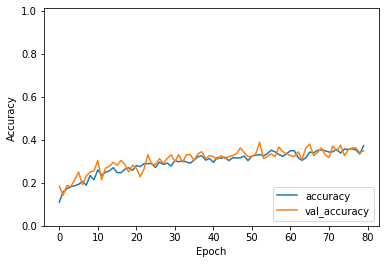

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1.01])
plt.legend(loc='lower right')

In [ ]:
test_steps = np.ceil(200/BATCH_SIZE)
test_loss, test_acc = model.evaluate(test_ds, verbose=1, steps=test_steps)
print(test_acc)

7/7 [==============================] - 1s 189ms/step - loss: 1.8675 - accuracy: 0.3482
0.3482142984867096


### Fine tuning of the entire model

In [ ]:
resnet_model.trainable = True

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(loss='categorical_crossentropy',
             optimizer=opt,
             metrics=['accuracy'])

In [ ]:
steps_per_epoch=np.ceil(800/BATCH_SIZE)
val_steps=np.ceil(200/BATCH_SIZE)

try:
    history = model.fit(train_ds, epochs=80, verbose=1,\
                    steps_per_epoch=steps_per_epoch,\
                    validation_data=test_ds,\
                    validation_steps=val_steps)
except KeyboardInterrupt:
    pass

Epoch 1/80
25/25 [==============================] - 18s 729ms/step - loss: 2.5282 - accuracy: 0.1688 - val_loss: 2.2292 - val_accuracy: 0.2232
Epoch 2/80
25/25 [==============================] - 17s 688ms/step - loss: 2.1352 - accuracy: 0.2050 - val_loss: 2.1528 - val_accuracy: 0.1741
Epoch 3/80
25/25 [==============================] - 17s 691ms/step - loss: 2.0761 - accuracy: 0.2325 - val_loss: 2.0970 - val_accuracy: 0.2679
Epoch 4/80
25/25 [==============================] - 17s 692ms/step - loss: 2.0001 - accuracy: 0.2438 - val_loss: 1.9237 - val_accuracy: 0.3304
Epoch 5/80
25/25 [==============================] - 17s 695ms/step - loss: 1.9699 - accuracy: 0.2850 - val_loss: 1.8686 - val_accuracy: 0.3304
Epoch 6/80
25/25 [==============================] - 17s 693ms/step - loss: 1.7766 - accuracy: 0.3413 - val_loss: 1.7020 - val_accuracy: 0.3125
Epoch 7/80
25/25 [==============================] - 17s 693ms/step - loss: 1.7272 - accuracy: 0.3587 - val_loss: 1.5906 - val_accuracy: 0.3839

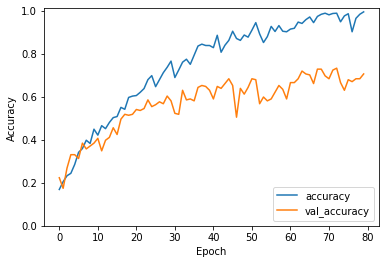

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1.01])
plt.legend(loc='lower right')

In [ ]:
test_steps = np.ceil(200/BATCH_SIZE)
test_loss, test_acc = model.evaluate(test_ds, verbose=1, steps=test_steps)
print(test_acc)

7/7 [==============================] - 1s 186ms/step - loss: 2.4186 - accuracy: 0.7054
0.7053571343421936


##Pretrained model using ResNet50 with less data augmentation

In [ ]:
resnet_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
resnet_model.trainable = False

In [ ]:
inputs = tf.keras.Input(shape=input_shape)

In [ ]:
firstPartModel = resnet_model(inputs, training=False)
firstPartModel = layers.GlobalAveragePooling2D()(firstPartModel)
firstPartModel = layers.Dropout(0.5)(firstPartModel)
firstPartModel = layers.Dense(10, activation='softmax')(firstPartModel)

In [ ]:
model = tf.keras.Model(inputs=inputs, outputs=firstPartModel)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_29 (Dense)             (None, 10)                20490     
Total params: 23,608,202
Trainable params: 20,490
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
model.compile(loss='categorical_crossentropy',
             optimizer='Adam',
             metrics=['accuracy'])

In [ ]:
stopping = EarlyStopping(monitor='val_accuracy', patience = 15, restore_best_weights = True)
steps_per_epoch=np.ceil(800/BATCH_SIZE)
val_steps=np.ceil(200/BATCH_SIZE)

try:
    history = model.fit(train_ds, epochs=120, verbose=1,\
                    callbacks = [stopping],\
                    steps_per_epoch=steps_per_epoch,\
                    validation_data=test_ds,\
                    validation_steps=val_steps)
except KeyboardInterrupt:
    pass

Epoch 1/120
25/25 [==============================] - 3s 113ms/step - loss: 2.6580 - accuracy: 0.1125 - val_loss: 2.2115 - val_accuracy: 0.1875
Epoch 2/120
25/25 [==============================] - 2s 77ms/step - loss: 2.4440 - accuracy: 0.1363 - val_loss: 2.1480 - val_accuracy: 0.1875
Epoch 3/120
25/25 [==============================] - 2s 77ms/step - loss: 2.3510 - accuracy: 0.1388 - val_loss: 2.1078 - val_accuracy: 0.1607
Epoch 4/120
25/25 [==============================] - 2s 82ms/step - loss: 2.2580 - accuracy: 0.1650 - val_loss: 2.0776 - val_accuracy: 0.2143
Epoch 5/120
25/25 [==============================] - 2s 81ms/step - loss: 2.2150 - accuracy: 0.1688 - val_loss: 2.0539 - val_accuracy: 0.2589
Epoch 6/120
25/25 [==============================] - 2s 76ms/step - loss: 2.1687 - accuracy: 0.1787 - val_loss: 2.0460 - val_accuracy: 0.2098
Epoch 7/120
25/25 [==============================] - 2s 82ms/step - loss: 2.1524 - accuracy: 0.1900 - val_loss: 2.0279 - val_accuracy: 0.2679
Epoch

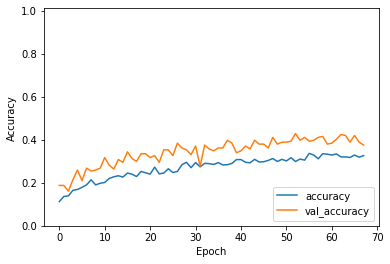

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1.01])
plt.legend(loc='lower right')

In [ ]:
test_steps = np.ceil(200/BATCH_SIZE)
test_loss, test_acc = model.evaluate(test_ds, verbose=1, steps=test_steps)
print(test_acc)

7/7 [==============================] - 0s 54ms/step - loss: 1.8415 - accuracy: 0.4286
0.4285714328289032


### Fine tuning of the entire model

In [ ]:
resnet_model.trainable = True

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(loss='categorical_crossentropy',
             optimizer=opt,
             metrics=['accuracy'])

In [ ]:
stopping = EarlyStopping(monitor='val_accuracy', patience = 15, restore_best_weights = True)
steps_per_epoch=np.ceil(800/BATCH_SIZE)
val_steps=np.ceil(200/BATCH_SIZE)

try:
    history = model.fit(train_ds, epochs=80, verbose=1,\
                    callbacks = [stopping],\
                    steps_per_epoch=steps_per_epoch,\
                    validation_data=test_ds,\
                    validation_steps=val_steps)
except KeyboardInterrupt:
    pass

Epoch 1/80
25/25 [==============================] - 6s 238ms/step - loss: 2.5225 - accuracy: 0.1500 - val_loss: 2.2290 - val_accuracy: 0.2143
Epoch 2/80
25/25 [==============================] - 5s 208ms/step - loss: 2.1978 - accuracy: 0.1725 - val_loss: 2.1041 - val_accuracy: 0.2277
Epoch 3/80
25/25 [==============================] - 5s 202ms/step - loss: 2.1156 - accuracy: 0.2200 - val_loss: 1.9991 - val_accuracy: 0.2232
Epoch 4/80
25/25 [==============================] - 5s 208ms/step - loss: 2.0756 - accuracy: 0.2325 - val_loss: 1.9256 - val_accuracy: 0.3125
Epoch 5/80
25/25 [==============================] - 5s 202ms/step - loss: 1.9803 - accuracy: 0.2625 - val_loss: 1.9914 - val_accuracy: 0.2500
Epoch 6/80
25/25 [==============================] - 5s 206ms/step - loss: 1.9195 - accuracy: 0.2837 - val_loss: 1.7372 - val_accuracy: 0.3750
Epoch 7/80
25/25 [==============================] - 5s 203ms/step - loss: 1.8330 - accuracy: 0.3275 - val_loss: 1.6782 - val_accuracy: 0.3616
Epoch 

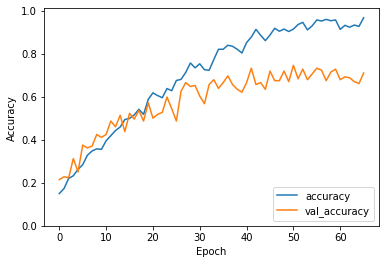

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1.01])
plt.legend(loc='lower right')

In [ ]:
test_steps = np.ceil(200/BATCH_SIZE)
test_loss, test_acc = model.evaluate(test_ds, verbose=1, steps=test_steps)
print(test_acc)

7/7 [==============================] - 0s 53ms/step - loss: 1.0423 - accuracy: 0.7455
0.7455357313156128


##Pretrained model using ResNet152 with full data augmentation

In [ ]:
resnet_model = tf.keras.applications.ResNet152(include_top=False, weights='imagenet', input_shape=input_shape)
resnet_model.trainable = False

In [ ]:
inputs = tf.keras.Input(shape=input_shape)

In [ ]:
firstPartModel = resnet_model(inputs, training=False)
firstPartModel = layers.GlobalAveragePooling2D()(firstPartModel)
firstPartModel = layers.Dropout(0.5)(firstPartModel)
firstPartModel = layers.Dense(10, activation='softmax')(firstPartModel)

In [ ]:
model = tf.keras.Model(inputs=inputs, outputs=firstPartModel)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet152 (Model)            (None, 7, 7, 2048)        58370944  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                20490     
Total params: 58,391,434
Trainable params: 20,490
Non-trainable params: 58,370,944
_________________________________________________________________


In [ ]:
model.compile(loss='categorical_crossentropy',
             optimizer='Adam',
             metrics=['accuracy'])

In [ ]:
stopping = EarlyStopping(monitor='val_accuracy', patience = 15, restore_best_weights = True)
steps_per_epoch=np.ceil(800/BATCH_SIZE)
val_steps=np.ceil(200/BATCH_SIZE)

try:
    history = model.fit(train_ds, epochs=120, verbose=1,\
                    callbacks = [stopping],\
                    steps_per_epoch=steps_per_epoch,\
                    validation_data=test_ds,\
                    validation_steps=val_steps)
except KeyboardInterrupt:
    pass

Epoch 1/120
25/25 [==============================] - 7s 272ms/step - loss: 2.5305 - accuracy: 0.1050 - val_loss: 2.2449 - val_accuracy: 0.1652
Epoch 2/120
25/25 [==============================] - 4s 167ms/step - loss: 2.4222 - accuracy: 0.1275 - val_loss: 2.2117 - val_accuracy: 0.1652
Epoch 3/120
25/25 [==============================] - 4s 167ms/step - loss: 2.2626 - accuracy: 0.1575 - val_loss: 2.1910 - val_accuracy: 0.1607
Epoch 4/120
25/25 [==============================] - 5s 183ms/step - loss: 2.2623 - accuracy: 0.1437 - val_loss: 2.1696 - val_accuracy: 0.1875
Epoch 5/120
25/25 [==============================] - 4s 180ms/step - loss: 2.2252 - accuracy: 0.1663 - val_loss: 2.1550 - val_accuracy: 0.1920
Epoch 6/120
25/25 [==============================] - 5s 180ms/step - loss: 2.1857 - accuracy: 0.1600 - val_loss: 2.1344 - val_accuracy: 0.3214
Epoch 7/120
25/25 [==============================] - 4s 167ms/step - loss: 2.1598 - accuracy: 0.1937 - val_loss: 2.1225 - val_accuracy: 0.2857

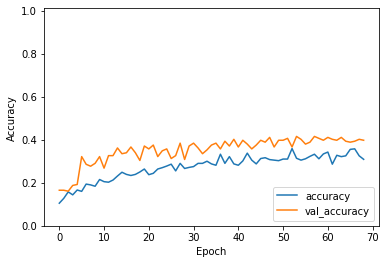

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1.01])
plt.legend(loc='lower right')

In [ ]:
test_steps = np.ceil(200/BATCH_SIZE)
test_loss, test_acc = model.evaluate(test_ds, verbose=1, steps=test_steps)
print(test_acc)

7/7 [==============================] - 1s 114ms/step - loss: 1.8937 - accuracy: 0.4152
0.4151785671710968


### Fine tuning of the entire model

In [ ]:
resnet_model.trainable = True

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(loss='categorical_crossentropy',
             optimizer=opt,
             metrics=['accuracy'])

In [ ]:
stopping = EarlyStopping(monitor='val_accuracy', patience = 15, restore_best_weights = True)
steps_per_epoch=np.ceil(800/BATCH_SIZE)
val_steps=np.ceil(200/BATCH_SIZE)

try:
    history = model.fit(train_ds, epochs=120, verbose=1,\
                    callbacks = [stopping],\
                    steps_per_epoch=steps_per_epoch,\
                    validation_data=test_ds,\
                    validation_steps=val_steps)
except KeyboardInterrupt:
    pass

Epoch 1/120
25/25 [==============================] - 14s 566ms/step - loss: 2.5627 - accuracy: 0.1538 - val_loss: 2.2236 - val_accuracy: 0.1741
Epoch 2/120
25/25 [==============================] - 12s 475ms/step - loss: 2.1538 - accuracy: 0.1950 - val_loss: 2.0568 - val_accuracy: 0.2679
Epoch 3/120
25/25 [==============================] - 12s 461ms/step - loss: 2.0547 - accuracy: 0.2362 - val_loss: 1.9786 - val_accuracy: 0.2589
Epoch 4/120
25/25 [==============================] - 12s 476ms/step - loss: 1.9975 - accuracy: 0.2525 - val_loss: 1.8597 - val_accuracy: 0.3125
Epoch 5/120
25/25 [==============================] - 12s 460ms/step - loss: 1.9108 - accuracy: 0.3038 - val_loss: 1.9410 - val_accuracy: 0.2589
Epoch 6/120
25/25 [==============================] - 12s 474ms/step - loss: 1.8343 - accuracy: 0.2962 - val_loss: 1.7885 - val_accuracy: 0.3348
Epoch 7/120
25/25 [==============================] - 12s 461ms/step - loss: 1.9013 - accuracy: 0.2900 - val_loss: 1.9883 - val_accuracy:

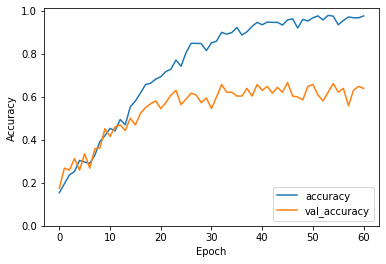

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1.01])
plt.legend(loc='lower right')

In [ ]:
test_steps = np.ceil(200/BATCH_SIZE)
test_loss, test_acc = model.evaluate(test_ds, verbose=1, steps=test_steps)
print(test_acc)

7/7 [==============================] - 1s 114ms/step - loss: 2.0978 - accuracy: 0.6652
0.6651785969734192


##Pretrained model using ResNet152 with less data augmentation

In [ ]:
resnet_model = tf.keras.applications.ResNet152(include_top=False, weights='imagenet', input_shape=input_shape)
resnet_model.trainable = False

234700800/234698864 [==============================] - 3s 0us/step


In [ ]:
inputs = tf.keras.Input(shape=input_shape)

In [ ]:
firstPartModel = resnet_model(inputs, training=False)
firstPartModel = layers.GlobalAveragePooling2D()(firstPartModel)
firstPartModel = layers.Dropout(0.5)(firstPartModel)
firstPartModel = layers.Dense(10, activation='softmax')(firstPartModel)

In [ ]:
model = tf.keras.Model(inputs=inputs, outputs=firstPartModel)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet152 (Model)            (None, 7, 7, 2048)        58370944  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 10)                20490     
Total params: 58,391,434
Trainable params: 20,490
Non-trainable params: 58,370,944
_________________________________________________________________


In [ ]:
model.compile(loss='categorical_crossentropy',
             optimizer='Adam',
             metrics=['accuracy'])

In [ ]:
stopping = EarlyStopping(monitor='val_accuracy', patience = 15, restore_best_weights = True)
steps_per_epoch=np.ceil(800/BATCH_SIZE)
val_steps=np.ceil(200/BATCH_SIZE)

try:
    history = model.fit(train_ds, epochs=120, verbose=1,\
                    callbacks = [stopping],\
                    steps_per_epoch=steps_per_epoch,\
                    validation_data=test_ds,\
                    validation_steps=val_steps)
except KeyboardInterrupt:
    pass

Epoch 1/120
25/25 [==============================] - 7s 273ms/step - loss: 2.5523 - accuracy: 0.1300 - val_loss: 2.2351 - val_accuracy: 0.1429
Epoch 2/120
25/25 [==============================] - 5s 183ms/step - loss: 2.4292 - accuracy: 0.1287 - val_loss: 2.1764 - val_accuracy: 0.2098
Epoch 3/120
25/25 [==============================] - 4s 179ms/step - loss: 2.3432 - accuracy: 0.1363 - val_loss: 2.1490 - val_accuracy: 0.2232
Epoch 4/120
25/25 [==============================] - 4s 167ms/step - loss: 2.3107 - accuracy: 0.1400 - val_loss: 2.1330 - val_accuracy: 0.2232
Epoch 5/120
25/25 [==============================] - 4s 167ms/step - loss: 2.2605 - accuracy: 0.1538 - val_loss: 2.1090 - val_accuracy: 0.2009
Epoch 6/120
25/25 [==============================] - 5s 181ms/step - loss: 2.1955 - accuracy: 0.1887 - val_loss: 2.0924 - val_accuracy: 0.3170
Epoch 7/120
25/25 [==============================] - 4s 166ms/step - loss: 2.1926 - accuracy: 0.1663 - val_loss: 2.0783 - val_accuracy: 0.2455

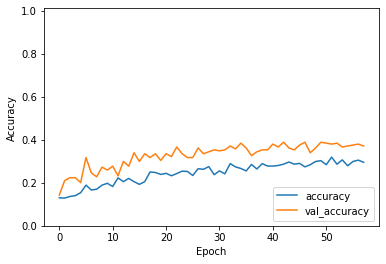

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1.01])
plt.legend(loc='lower right')

In [ ]:
test_steps = np.ceil(200/BATCH_SIZE)
test_loss, test_acc = model.evaluate(test_ds, verbose=1, steps=test_steps)
print(test_acc)

7/7 [==============================] - 1s 115ms/step - loss: 1.8957 - accuracy: 0.3884
0.3883928656578064


### Fine tuning of the entire model

In [ ]:
resnet_model.trainable = True

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(loss='categorical_crossentropy',
             optimizer=opt,
             metrics=['accuracy'])

In [ ]:
stopping = EarlyStopping(monitor='val_accuracy', patience = 15, restore_best_weights = True)
steps_per_epoch=np.ceil(800/BATCH_SIZE)
val_steps=np.ceil(200/BATCH_SIZE)

try:
    history = model.fit(train_ds, epochs=120, verbose=1,\
                    callbacks = [stopping],\
                    steps_per_epoch=steps_per_epoch,\
                    validation_data=test_ds,\
                    validation_steps=val_steps)
except KeyboardInterrupt:
    pass

Epoch 1/120
25/25 [==============================] - 14s 571ms/step - loss: 2.5093 - accuracy: 0.1338 - val_loss: 2.2398 - val_accuracy: 0.1562
Epoch 2/120
25/25 [==============================] - 12s 478ms/step - loss: 2.2270 - accuracy: 0.1650 - val_loss: 2.1165 - val_accuracy: 0.1964
Epoch 3/120
25/25 [==============================] - 12s 476ms/step - loss: 2.1880 - accuracy: 0.1688 - val_loss: 2.0144 - val_accuracy: 0.2366
Epoch 4/120
25/25 [==============================] - 12s 476ms/step - loss: 2.0478 - accuracy: 0.2200 - val_loss: 1.8984 - val_accuracy: 0.2902
Epoch 5/120
25/25 [==============================] - 12s 476ms/step - loss: 1.9381 - accuracy: 0.2763 - val_loss: 1.8595 - val_accuracy: 0.3170
Epoch 6/120
25/25 [==============================] - 12s 476ms/step - loss: 1.7458 - accuracy: 0.3462 - val_loss: 1.6164 - val_accuracy: 0.4062
Epoch 7/120
25/25 [==============================] - 12s 464ms/step - loss: 1.7277 - accuracy: 0.3700 - val_loss: 1.7907 - val_accuracy:

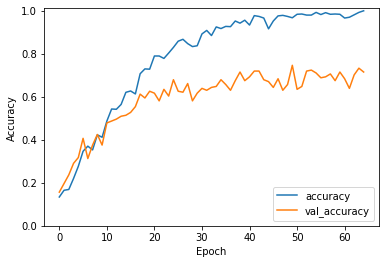

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1.01])
plt.legend(loc='lower right')

In [ ]:
test_steps = np.ceil(200/BATCH_SIZE)
test_loss, test_acc = model.evaluate(test_ds, verbose=1, steps=test_steps)
print(test_acc)

7/7 [==============================] - 1s 115ms/step - loss: 1.0779 - accuracy: 0.7455
0.7455357313156128


##Pretrained model using VGG with full data augmentation

In [ ]:
vgg_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
vgg_model.trainable = False

80142336/80134624 [==============================] - 2s 0us/step


In [ ]:
inputs = tf.keras.Input(shape=input_shape)

In [ ]:
firstPartModel = vgg_model(inputs)
firstPartModel = layers.GlobalAveragePooling2D()(firstPartModel)
firstPartModel = layers.Dropout(0.5)(firstPartModel)
firstPartModel = layers.Dense(10, activation='softmax')(firstPartModel)

In [ ]:
model = tf.keras.Model(inputs=inputs, outputs=firstPartModel)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 20,029,514
Trainable params: 5,130
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
model.compile(loss='categorical_crossentropy',
             optimizer='Adam',
             metrics=['accuracy'])

In [ ]:
stopping = EarlyStopping(monitor='val_accuracy', patience = 15, restore_best_weights = True)
steps_per_epoch=np.ceil(800/BATCH_SIZE)
val_steps=np.ceil(200/BATCH_SIZE)

try:
    history = model.fit(train_ds, epochs=120, verbose=1,\
                    callbacks = [stopping],\
                    steps_per_epoch=steps_per_epoch,\
                    validation_data=test_ds,\
                    validation_steps=val_steps)
except KeyboardInterrupt:
    pass

Epoch 1/120
25/25 [==============================] - 3s 128ms/step - loss: 2.4547 - accuracy: 0.1037 - val_loss: 2.1909 - val_accuracy: 0.2143
Epoch 2/120
25/25 [==============================] - 3s 122ms/step - loss: 2.2481 - accuracy: 0.1737 - val_loss: 2.0724 - val_accuracy: 0.3616
Epoch 3/120
25/25 [==============================] - 3s 122ms/step - loss: 2.1750 - accuracy: 0.1900 - val_loss: 1.9748 - val_accuracy: 0.4554
Epoch 4/120
25/25 [==============================] - 3s 122ms/step - loss: 2.0741 - accuracy: 0.2412 - val_loss: 1.8905 - val_accuracy: 0.4688
Epoch 5/120
25/25 [==============================] - 3s 121ms/step - loss: 1.9553 - accuracy: 0.2837 - val_loss: 1.8205 - val_accuracy: 0.4866
Epoch 6/120
25/25 [==============================] - 3s 121ms/step - loss: 1.8897 - accuracy: 0.3425 - val_loss: 1.7570 - val_accuracy: 0.5312
Epoch 7/120
25/25 [==============================] - 3s 122ms/step - loss: 1.8127 - accuracy: 0.3862 - val_loss: 1.7012 - val_accuracy: 0.5536

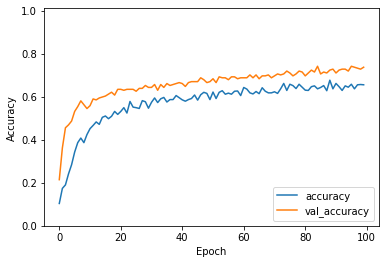

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1.01])
plt.legend(loc='lower right')

In [ ]:
test_steps = np.ceil(200/BATCH_SIZE)
test_loss, test_acc = model.evaluate(test_ds, verbose=1, steps=test_steps)
print(test_acc)

7/7 [==============================] - 1s 81ms/step - loss: 0.9407 - accuracy: 0.7411
0.7410714030265808


### Fine tuning of the entire model

In [ ]:
vgg_model.trainable = True

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(loss='categorical_crossentropy',
             optimizer=opt,
             metrics=['accuracy'])

In [ ]:
stopping = EarlyStopping(monitor='val_accuracy', patience = 15, restore_best_weights = True)
steps_per_epoch=np.ceil(800/BATCH_SIZE)
val_steps=np.ceil(200/BATCH_SIZE)

try:
    history = model.fit(train_ds, epochs=120, verbose=1,\
                    callbacks = [stopping],\
                    steps_per_epoch=steps_per_epoch,\
                    validation_data=test_ds,\
                    validation_steps=val_steps)
except KeyboardInterrupt:
    pass

Epoch 1/120
25/25 [==============================] - 7s 287ms/step - loss: 0.9326 - accuracy: 0.6687 - val_loss: 0.7224 - val_accuracy: 0.7500
Epoch 2/120
25/25 [==============================] - 7s 278ms/step - loss: 0.7367 - accuracy: 0.7350 - val_loss: 0.6676 - val_accuracy: 0.7143
Epoch 3/120
25/25 [==============================] - 7s 281ms/step - loss: 0.5979 - accuracy: 0.7788 - val_loss: 0.5956 - val_accuracy: 0.7723
Epoch 4/120
25/25 [==============================] - 7s 281ms/step - loss: 0.5060 - accuracy: 0.8225 - val_loss: 0.5119 - val_accuracy: 0.8080
Epoch 5/120
25/25 [==============================] - 7s 281ms/step - loss: 0.4406 - accuracy: 0.8388 - val_loss: 0.4681 - val_accuracy: 0.8259
Epoch 6/120
25/25 [==============================] - 7s 279ms/step - loss: 0.3685 - accuracy: 0.8637 - val_loss: 0.5087 - val_accuracy: 0.8036
Epoch 7/120
25/25 [==============================] - 7s 278ms/step - loss: 0.3206 - accuracy: 0.8913 - val_loss: 0.4383 - val_accuracy: 0.8214

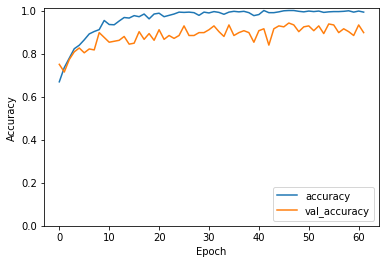

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1.01])
plt.legend(loc='lower right')

In [ ]:
test_steps = np.ceil(200/BATCH_SIZE)
test_loss, test_acc = model.evaluate(test_ds, verbose=1, steps=test_steps)
print(test_acc)

7/7 [==============================] - 1s 84ms/step - loss: 0.2531 - accuracy: 0.9420
0.9419642686843872


##Pretrained model using VGG with less data augmentation

In [ ]:
vgg_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
vgg_model.trainable = False

In [ ]:
inputs = tf.keras.Input(shape=input_shape)

In [ ]:
firstPartModel = vgg_model(inputs)
firstPartModel = layers.GlobalAveragePooling2D()(firstPartModel)
firstPartModel = layers.Dropout(0.5)(firstPartModel)
firstPartModel = layers.Dense(10, activation='softmax')(firstPartModel)

In [ ]:
model = tf.keras.Model(inputs=inputs, outputs=firstPartModel)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                5130      
Total params: 20,029,514
Trainable params: 5,130
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
model.compile(loss='categorical_crossentropy',
             optimizer='Adam',
             metrics=['accuracy'])

In [ ]:
stopping = EarlyStopping(monitor='val_accuracy', patience = 15, restore_best_weights = True)
steps_per_epoch=np.ceil(800/BATCH_SIZE)
val_steps=np.ceil(200/BATCH_SIZE)

try:
    history = model.fit(train_ds, epochs=120, verbose=1,\
                    callbacks = [stopping],\
                    steps_per_epoch=steps_per_epoch,\
                    validation_data=test_ds,\
                    validation_steps=val_steps)
except KeyboardInterrupt:
    pass

Epoch 1/120
25/25 [==============================] - 5s 218ms/step - loss: 2.6107 - accuracy: 0.1063 - val_loss: 2.2417 - val_accuracy: 0.1875
Epoch 2/120
25/25 [==============================] - 3s 123ms/step - loss: 2.4217 - accuracy: 0.1412 - val_loss: 2.1403 - val_accuracy: 0.2545
Epoch 3/120
25/25 [==============================] - 3s 123ms/step - loss: 2.2177 - accuracy: 0.1737 - val_loss: 2.0219 - val_accuracy: 0.4062
Epoch 4/120
25/25 [==============================] - 3s 121ms/step - loss: 2.1020 - accuracy: 0.2300 - val_loss: 1.9428 - val_accuracy: 0.4554
Epoch 5/120
25/25 [==============================] - 3s 122ms/step - loss: 1.9873 - accuracy: 0.2912 - val_loss: 1.8640 - val_accuracy: 0.5089
Epoch 6/120
25/25 [==============================] - 3s 121ms/step - loss: 1.9243 - accuracy: 0.3075 - val_loss: 1.7916 - val_accuracy: 0.5134
Epoch 7/120
25/25 [==============================] - 3s 123ms/step - loss: 1.8429 - accuracy: 0.3650 - val_loss: 1.7320 - val_accuracy: 0.5491

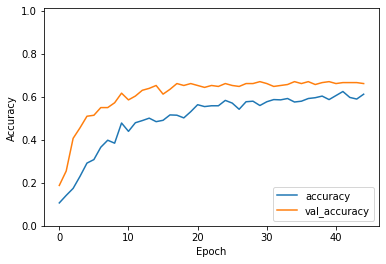

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1.01])
plt.legend(loc='lower right')

In [ ]:
test_steps = np.ceil(200/BATCH_SIZE)
test_loss, test_acc = model.evaluate(test_ds, verbose=1, steps=test_steps)
print(test_acc)

7/7 [==============================] - 1s 81ms/step - loss: 1.1750 - accuracy: 0.6696
0.6696428656578064


### Fine tuning of the entire model

In [ ]:
vgg_model.trainable = True

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(loss='categorical_crossentropy',
             optimizer=opt,
             metrics=['accuracy'])

In [ ]:
stopping = EarlyStopping(monitor='val_accuracy', patience = 15, restore_best_weights = True)
steps_per_epoch=np.ceil(800/BATCH_SIZE)
val_steps=np.ceil(200/BATCH_SIZE)

try:
    history = model.fit(train_ds, epochs=120, verbose=1,\
                    callbacks = [stopping],\
                    steps_per_epoch=steps_per_epoch,\
                    validation_data=test_ds,\
                    validation_steps=val_steps)
except KeyboardInterrupt:
    pass

Epoch 1/120
25/25 [==============================] - 7s 287ms/step - loss: 1.0684 - accuracy: 0.6350 - val_loss: 0.8072 - val_accuracy: 0.6786
Epoch 2/120
25/25 [==============================] - 7s 280ms/step - loss: 0.7910 - accuracy: 0.7050 - val_loss: 0.6796 - val_accuracy: 0.7545
Epoch 3/120
25/25 [==============================] - 7s 281ms/step - loss: 0.6748 - accuracy: 0.7563 - val_loss: 0.5791 - val_accuracy: 0.7857
Epoch 4/120
25/25 [==============================] - 7s 280ms/step - loss: 0.6486 - accuracy: 0.7613 - val_loss: 0.5280 - val_accuracy: 0.8304
Epoch 5/120
25/25 [==============================] - 7s 280ms/step - loss: 0.5268 - accuracy: 0.7962 - val_loss: 0.4418 - val_accuracy: 0.8438
Epoch 6/120
25/25 [==============================] - 7s 281ms/step - loss: 0.4141 - accuracy: 0.8500 - val_loss: 0.4358 - val_accuracy: 0.8571
Epoch 7/120
25/25 [==============================] - 7s 279ms/step - loss: 0.4094 - accuracy: 0.8338 - val_loss: 0.3953 - val_accuracy: 0.8527

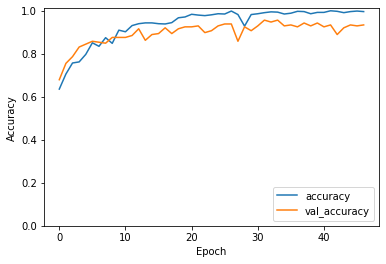

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1.01])
plt.legend(loc='lower right')

In [ ]:
test_steps = np.ceil(200/BATCH_SIZE)
test_loss, test_acc = model.evaluate(test_ds, verbose=1, steps=test_steps)
print(test_acc)

7/7 [==============================] - 1s 83ms/step - loss: 0.2002 - accuracy: 0.9554
0.9553571343421936
